In [1]:
import config.config as cf
import json

import numpy as np
import subprocess
from pathlib import Path
import os
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


2025-10-13 20:15:28,188 - logger - INFO - Logger initialized


# Data Aggregation

In [7]:
# region gathering data from json summary files
data_211 = {'val': {}, 'test': {}}

trainer = "nnUNetTrainer_100epochs__nnUNetResEncUNetMPlans__3d_fullres"

dataset_211_validation = Path(f"{cf.nnunet_trained_models}/{cf.dataset_211}/{trainer}")
dataset_211_test = Path(f"{cf.nnunet_predictions}/{cf.dataset_211}")


for i in range(5):
    json_validation_211 = dataset_211_validation / f"fold_{i}/validation/summary.json"
    if json_validation_211.exists():
        with open(json_validation_211) as f:
            data_211["val"][f"fold_{i}"] = json.load(f)

    json_test_211 = dataset_211_test / f"fold_{i}/summary.json"

    if json_test_211.exists():
        with open(json_test_211) as f:
            data_211["test"][f"fold_{i}"] = json.load(f)

for sub in ["", "postprocessed"]:
    json_validation_211 = dataset_211_validation / "crossval_results_folds_0_1_2_3_4" / sub / "summary.json"

    label = "fold_01234_postprocessing" if sub else "fold_01234"
    if json_validation_211.exists():
        with open(json_validation_211) as f:
            data_211["val"][label] = json.load(f)

for name in ["fold_01234", "fold_01234_postprocessing"]:
    json_test_211 = dataset_211_test / name / "summary.json"

    if json_test_211.exists():
        with open(json_test_211) as f:
            data_211["test"][name] = json.load(f)

# endregion

In [8]:
def extract_patient_metrics(data_dict):
    records = []
    for fold, content in data_dict["test"].items():
        for entry in content.get("metric_per_case", []):
            patient_path = Path(entry["prediction_file"])
            patient_file = patient_path.name.replace(".nii.gz", "") 

            metrics = entry["metrics"]["1"]

            records.append(
                {
                    "fold": fold,
                    **metrics,
                }
            )
    return pd.DataFrame(records)


df_patients_211 = extract_patient_metrics(data_211)


In [9]:
def extract_foreground_means(data_dict, label, df_patients=None):
    records = []
    for fold, content in data_dict.items():
        fg = content.get("foreground_mean")
        if fg:
            records.append({"dataset": label, "split": "val", "fold": fold, **fg})

    if df_patients is not None:
        grouped = df_patients.groupby("fold").mean().reset_index()
        for _, row in grouped.iterrows():
            records.append({
                "dataset": label,
                "split": "test",
                "fold": row["fold"],
                "Dice": row["Dice"],
                "FN": row["FN"],
                "FP": row["FP"],
                "TN": row["TN"],
                "TP": row["TP"],
                "n_pred": row["n_pred"],
                "n_ref": row["n_ref"],
                "IoU": row["IoU"]
            })

    return pd.DataFrame(records)


df_mean_211 = extract_foreground_means(data_211["val"], "211",df_patients_211)


In [10]:
df_mean_211

,dataset,split,fold,Dice,FN,FP,IoU,TN,TP,n_pred,n_ref
0,211,val,fold_0,0.761311,2971.933333,1084.733333,0.622274,7.208314e+06,8661.333333,9746.066667,11633.266667
1,211,val,fold_1,0.762903,5210.800000,1382.500000,0.625556,7.199051e+06,15388.100000,16770.600000,20598.900000
2,211,val,fold_2,0.596400,1411.000000,2117.538462,0.448464,7.214690e+06,2813.384615,4930.923077,4224.384615
3,211,val,fold_3,0.693141,2530.421053,1686.315789,0.562255,7.208212e+06,8603.736842,10290.052632,11134.157895
4,211,val,fold_4,0.728384,1225.392857,3689.000000,0.588036,7.205552e+06,10566.000000,14255.000000,11791.392857
5,211,val,fold_01234,0.710192,2322.576471,2270.070588,0.571383,7.207266e+06,9172.870588,11442.941176,11495.447059
6,211,val,fold_01234_postprocessing,0.710192,2322.576471,2270.070588,0.571383,7.207266e+06,9172.870588,11442.941176,11495.447059
7,211,test,fold_0,0.701369,2891.636364,2199.090909,0.549015,7.208601e+06,7339.909091,9539.000000,10231.545455
8,211,test,fold_01234,0.711113,2961.500000,2000.772727,0.560512,7.208800e+06,7270.045455,9270.818182,10231.545455
9,211,test,fold_01234_postprocessing,0.711113,2961.500000,2000.772727,0.560512,7.208800e+06,7270.045455,9270.818182,10231.545455


# Latex Tables

In [8]:
# region generate latex tables for thesis
def generate_latex_table(df_mean, caption, label):
    row_order = ["fold_0", "fold_1", "fold_2", "fold_3", "fold_4", "fold_01234", "fold_01234_postprocessing"]

    row_labels = {
        "fold_0": "Fold 0",
        "fold_1": "Fold 1",
        "fold_2": "Fold 2",
        "fold_3": "Fold 3",
        "fold_4": "Fold 4",
        "fold_01234": "Fold 0 - 4",
        "fold_01234_postprocessing": "Fold 0 - 4 (Postprocessed)"
    }

    val_dice_max = df_mean.query("split == 'val'")["Dice"].max()
    val_iou_max = df_mean.query("split == 'val'")["IoU"].max()
    test_dice_max = df_mean.query("split == 'test'")["Dice"].max()
    test_iou_max = df_mean.query("split == 'test'")["IoU"].max()

    latex_rows = []
    for row in row_order:
        row_label = row_labels[row]
        val = df_mean.query("split == 'val' and fold == @row")
        test = df_mean.query("split == 'test' and fold == @row")

        def fmt(value, max_val):
            return f"\\textbf{{{value:.4f}}}" if np.isclose(value, max_val) else f"{value:.4f}"

        val_dice_str = fmt(val["Dice"].values[0], val_dice_max) if not val.empty else "-"
        val_iou_str = fmt(val["IoU"].values[0], val_iou_max) if not val.empty else "-"
        test_dice_str = fmt(test["Dice"].values[0], test_dice_max) if not test.empty else "-"
        test_iou_str = fmt(test["IoU"].values[0], test_iou_max) if not test.empty else "-"

        latex_rows.append(f"{row_label} & {val_dice_str} & {val_iou_str} & {test_dice_str} & {test_iou_str} \\\\")

    latex_table = r"""\begin{table}[h!]
\centering
\small
\begin{tabular}{c c c c c}
\toprule
\multirow{2}{*}{\textbf{Evaluation Setup}} & \multicolumn{2}{c}{\textbf{Validation}} & \multicolumn{2}{c}{\textbf{Test}} \\
& \textbf{Dice} & \textbf{IoU} & \textbf{Dice} & \textbf{IoU} \\
\midrule
""" + "\n".join(latex_rows) + r"""
\bottomrule
\end{tabular}
\caption{""" + caption + r"""}
\label{""" + label + r"""}
\end{table}
\FloatBarrier"""
    return latex_table


caption_211 = "Mean segmentation performance across folds for validation and test set (Dice coefficient and IoU) of the MSLesSeg2024 challenge dataset."
label_211 = "tab:mslesseg_211_withoutskull"
latex_table_200 = generate_latex_table(df_mean_211, caption_211, label_211)

print(latex_table_200)
# endregion

\begin{table}[h!]
\centering
\small
\begin{tabular}{c c c c c}
\toprule
\multirow{2}{*}{\textbf{Evaluation Setup}} & \multicolumn{2}{c}{\textbf{Validation}} & \multicolumn{2}{c}{\textbf{Test}} \\
& \textbf{Dice} & \textbf{IoU} & \textbf{Dice} & \textbf{IoU} \\
\midrule
Fold 0 & 0.7613 & 0.6223 & 0.7014 & 0.5490 \\
Fold 1 & \textbf{0.7629} & \textbf{0.6256} & 0.7074 & 0.5549 \\
Fold 2 & 0.5964 & 0.4485 & 0.6768 & 0.5312 \\
Fold 3 & 0.6931 & 0.5623 & 0.7051 & 0.5523 \\
Fold 4 & 0.7284 & 0.5880 & 0.7044 & 0.5539 \\
Fold 0 - 4 & 0.7102 & 0.5714 & \textbf{0.7111} & \textbf{0.5605} \\
Fold 0 - 4 (Postprocessed) & 0.7102 & 0.5714 & \textbf{0.7111} & \textbf{0.5605} \\
\bottomrule
\end{tabular}
\caption{Mean segmentation performance across folds for validation and test set (Dice coefficient and IoU) of the MSLesSeg2024 challenge dataset.}
\label{tab:mslesseg_211_withoutskull}
\end{table}
\FloatBarrier


# Data Analysis

In [28]:
team_dices = [0.7146, 0.7083, 0.7079, 0.6974, 0.6859, 0.6783, 0.6754, 0.6508, 0.6503, 0.6446, 0.6357, 0.6101, 0.5683, 0.5471, 0.4985]
df_mslesseg = pd.DataFrame(team_dices)

data_mslesseg = [
    {"Dice":df_mean_211[(df_mean_211['split'] =="test") & (df_mean_211['fold'] == "fold_01234_postprocessing")]["Dice"].item(), "Team": "My Model"},
    {"Dice":team_dices[0], "Team": "MadSeg"},
    {"Dice":team_dices[1], "Team": "BrainS"},
    {"Dice":team_dices[2], "Team": "M3S: MeetMIALMS"},
    {"Dice":sum(team_dices) / len(team_dices), "Team": "Teams Average"},
]
df_mslesseg = pd.DataFrame(data_mslesseg)

In [27]:
df_mean_211[(df_mean_211['split'] =="test") & (df_mean_211['fold'] == "fold_01234_postprocessing")]["Dice"].item()

0.7111132495227851

# Lesion detection evaluation

In [ ]:
def metrics(dataset, fold="fold_01234_postprocessing"):
    pred_dir = Path(f"{cf.nnunet_predictions}/{dataset}/{fold}")
    output_dir_lesion_detection = Path(f"{cf.nnunet_predictions}/{dataset}/{fold}/lesion_detection")
    output_dir_lesion_detection.mkdir(exist_ok=True)
    output_dir_metrics = Path(f"{cf.nnunet_predictions}/{dataset}/{fold}/metrics")
    output_dir_metrics.mkdir(exist_ok=True)

    headers = [
        "Patient", "Jaccard", "Dice", "Sensitivity", "Specificity", "PPV", "NPV",
        "RelativeVolumeError", "HausdorffDistance", "ContourMeanDistance",
        "SurfaceDistance", "PPVL", "SensL", "F1_score"
    ]
    df = pd.DataFrame(columns=headers)

    for gt_file in Path(f"{cf.nnUNet_raw}/{dataset}/labelsTs").glob("*.nii.gz"):
        patient = gt_file.stem.replace(".nii", "")
        pred_file = pred_dir / f"{patient}.nii.gz"
        if not pred_file.exists():
            print(f"Prediction file of {patient} is missing.")
            continue

        output_prefix = output_dir_lesion_detection / f"{patient}_lesion_detection.txt"

        metrics_path = evaluate_lesions(gt_file, pred_file, output_prefix)

        segperf_path = segperfanalyzer(gt_file, pred_file, output_dir_metrics / "temp")
        if not segperf_path.exists():
            continue

        with open(segperf_path, 'r') as f:
            line = f.read()

        data = line.strip().replace("\t", "").split(";")

        full_row = [patient] + data[:-3]

        df.loc[len(df)] = full_row

        if segperf_path and segperf_path.exists():
            print(f"{patient}: Successful → {segperf_path}")
        else:
            print(f"{patient}: Anima Error")

    os.remove(output_dir_metrics / "temp_global.txt")
    df.to_csv(output_dir_metrics / f"metrics.csv", index=False, sep=";")


def evaluate_lesions(gt_path, pred_path, output_prefix, alpha=0.1, beta=0.7, gamma=0.65):
    cmd = [
        "animaDetectedComponents.exe",
        "-o", str(output_prefix),
        "-t", str(pred_path),
        "-r", str(gt_path),
        '-a', str(alpha),
        '-b', str(beta),
        '-g', str(gamma)
    ]

    try:
        subprocess.run(cmd, capture_output=True, text=True)
        return Path(f"{output_prefix}")
    except subprocess.CalledProcessError as e:
        print(f"Error with Anima: {e}")
        return None


def segperfanalyzer(gt_path, pred_path, output_prefix):
    cmd = [
        "animaSegPerfAnalyzer.exe",
        "-d",
        "-l",
        "-s",
        "-t", "8",
        "-o", str(output_prefix),
        "-i", str(pred_path),
        "-r", str(gt_path),
    ]
    print(" ".join(cmd))

    try:
        subprocess.run(cmd)
        return Path(f"{output_prefix}_global.txt")
    except subprocess.CalledProcessError as e:
        print(f"Error with Anima: {e}")
        return None

for i in range(5):
    metrics(cf.dataset_211, f"fold_{i}")
metrics(cf.dataset_211)

In [13]:
def extract_lesion_header_summary(dataset, fold="fold_01234_postprocessing"):
    path = Path(cf.nnunet_predictions, dataset, fold, "lesion_detection")
    files = path.glob("*.txt")

    all_summaries = []

    for file in files:

        with open(file, "r") as f:
            lines = [line.strip() for line in f.readlines()[:3]]

        try:
            total_ref_objects = int(lines[0].split(",")[1])
            total_volume = float(lines[2].split(",")[1]) / 1000.0
        except (IndexError, ValueError):
            continue

        patient = file.stem.split("_")[0]

        summary = {
            "patient": patient,
            "Number of lesions": total_ref_objects,
            "Total lesionload": total_volume
        }

        all_summaries.append(summary)

    return pd.DataFrame(all_summaries)

df = extract_lesion_header_summary(cf.dataset_211)
    

In [20]:
for i in [0,1,2,3,4,"01234_postprocessing"]:
    df_211 = pd.read_csv(Path(f"{cf.nnunet_predictions}/{cf.dataset_211}/fold_{i}/metrics/metrics.csv"), delimiter=";")
    df_211['Number of lesions'] = df['Number of lesions']
    df_211['Total lesionload'] = df['Total lesionload']
    
    df_211.to_csv(f"{cf.nnunet_predictions}/{cf.dataset_211}/fold_{i}/metrics/metrics.csv", sep=";", index=False)

In [2]:
df_211 = pd.read_csv(Path(f"{cf.nnunet_predictions}/{cf.dataset_211}/fold_01234_postprocessing/metrics/metrics.csv"), delimiter=";")

In [ ]:

def plot_metrics_lesion(df):
    fig, axs = plt.subplots(3, 2, figsize=(13, 13))
    metrics = ['Dice', 'F1_score', 'SurfaceDistance']
    x_vals = ['Number of lesions', 'Total lesionload']
    x_labels = ['Number of lesions', 'Total lesion load ($\mathrm{cm}^3$)']
    y_labels = ['Dice score', 'F1Score', 'Average surface distance (mm)']
    subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f']
    
    for i, metric in enumerate(metrics):
        for j, x in enumerate(x_vals):
            ax = axs[i, j]
            idx = i * 2 + j
            
            x_raw = df[x].replace(0, np.nan)  
            y_raw = df[metric]
            x_log = np.log10(x_raw)
    
            valid = x_log.notna() & y_raw.notna()
            x_clean = x_raw[valid]       
            y_clean = y_raw[valid]
            x_for_fit = x_log[valid]    
    
            ax.scatter(x_clean, y_clean, s=30, alpha=0.8)
    
            model = LinearRegression()
            model.fit(x_for_fit.values.reshape(-1, 1), y_clean.values)
            x_sorted = np.sort(x_clean)
            x_pred = np.log10(x_sorted).reshape(-1, 1)
            y_pred = model.predict(x_pred)
            ax.plot(x_sorted, y_pred, color='red', linewidth=2, label='Regression')
    
            rho_p, _ = pearsonr(x_log, y_clean)
            r2_text = f"$R^2$ = {rho_p ** 2:.4f}"
    
            ax.text(0.95, 0.5,
            r2_text,
            fontsize=10,
            transform=ax.transAxes,
            color='red',
            ha='right', va='center',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
          
            ax.set_xlabel(x_labels[j], fontsize=11)
            ax.set_ylabel(y_labels[i], fontsize=11)
    
            ax.text(0.5, -0.25, f"({subplot_labels[idx]})", transform=ax.transAxes,
                    ha='center', va='center', fontsize=12, fontweight='bold')
    

    fig.suptitle("Relationship between metric scores (dice, f1 and avg. surface distance) and number of lesions (first column) and total lesion load (second column in $\mathrm{cm}^3$)).", fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.4)
    fig.savefig("plots/mslesseg_lesion_metrics_plot.png", bbox_inches="tight")
    plt.show()

plot_metrics_lesion(df_211)

In [15]:
def extract_lesion_detection(dataset,fold="fold_01234_postprocessing"):
    path = Path(cf.nnunet_predictions, dataset, fold, "lesion_detection")
    files = path.glob("*.txt")
    
    all_lesions = []
    for file in files:
        df = pd.read_csv(file, skiprows=3)
        df.columns = ["Object number", "volume", "detected"]
        # Center und Patient aus dem Dateinamen extrahieren
        parts = file.stem.split("_")
        patient = parts[0]
        
        df["volume"] = df["volume"] / 1000.0
    
        df["patient"] = patient
    
        # Relevante Spalten sammeln
        all_lesions.append(df[["patient", "volume", "detected"]])
    return pd.concat(all_lesions, ignore_index=True)
    
df_all_lesions_200 = extract_lesion_detection(cf.dataset_211)

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
C:\Users\User\AppData\Local\Temp\ipykernel_1660\2366158112.py:29: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Lesion volume ($\mathrm{cm}^3$, log scale)", fontsize=12)


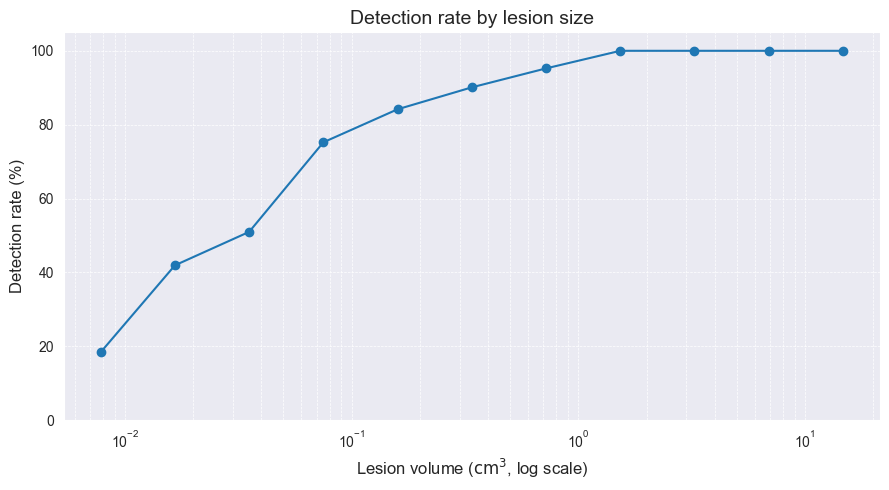

In [19]:

log_bins = np.logspace(np.log10(5 / 1000), np.log10(20000 / 1000), num=12)
bin_centers = (log_bins[:-1] + log_bins[1:]) / 2

def compute_detection_rates(df, bins):
    detection_rates = []
    for i in range(len(bins) - 1):
        bin_mask = (df['volume'] >= bins[i]) & (df['volume'] < bins[i+1])
        n_in_bin = bin_mask.sum()
        if n_in_bin > 0:
            rate = df.loc[bin_mask, 'detected'].sum() / n_in_bin * 100
        else:
            rate = np.nan
        detection_rates.append(rate)
    return detection_rates

rates_200 = compute_detection_rates(df_all_lesions_200, log_bins)

plt.figure(figsize=(9, 5))
plt.plot(bin_centers, rates_200, marker='o', color='tab:blue')

plt.xscale('log')
plt.ylim(0, 105)
plt.xlabel("Lesion volume ($\mathrm{cm}^3$, log scale)", fontsize=12)
plt.ylabel("Detection rate (%)", fontsize=12)
plt.title("Detection rate by lesion size", fontsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("plots/mslesseg_lesion_detection.png")
plt.show()


df

In [4]:
def generate_latex_table(df, caption: str, label: str) -> str:
    segmentation_metrics = ["Dice", "Jaccard", "Sensitivity", "PPV"]
    lesion_metrics = ["SensL", "PPVL", "F1_score"]
    all_metrics = segmentation_metrics + lesion_metrics

    display_names = {
        "Dice": "Dice",
        "Jaccard": "IoU",
        "Sensitivity": "Sensitivity",
        "PPV": "Precision",
        "SensL": "Sensitivity",
        "PPVL": "PPVL.",
        "F1_score": "F1 Score"
    }

    all_mean = df[all_metrics].mean().round(4)

    row_str = "".join(f" & {all_mean[metric]:.4f}" for metric in all_metrics) + r" \\"
    row_str = row_str[2:]
    
    header_line1 = r"\multicolumn{4}{c}{\textbf{Segmentation Metrics}} & \multicolumn{3}{c}{\textbf{Lesion Metrics}} \\"
    header_line2 = " & ".join([f"\\textbf{{{display_names[m]}}}" for m in all_metrics]) + r" \\"

    latex_table = r"""\begin{table}[h!]
\centering
\small
\begin{tabular}{c c c c c c c c}
\toprule
""" + header_line1 + "\n" + header_line2 + r"""
\midrule
""" + row_str + r"""
\bottomrule
\end{tabular}
\caption{""" + caption + r"""}
\label{""" + label + r"""}
\end{table}
\FloatBarrier"""

    return latex_table

print(generate_latex_table(df_211, "", "tab:mslesseg_all_metrics"))

\begin{table}[h!]
\centering
\small
\begin{tabular}{c c c c c c c c}
\toprule
\multicolumn{4}{c}{\textbf{Segmentation Metrics}} & \multicolumn{3}{c}{\textbf{Lesion Metrics}} \\
\textbf{Dice} & \textbf{IoU} & \textbf{Sensitivity} & \textbf{Precision} & \textbf{Sensitivity} & \textbf{PPVL.} & \textbf{F1 Score} \\
\midrule
 0.7111 & 0.5605 & 0.6919 & 0.7518 & 0.7338 & 0.7241 & 0.7098 \\
\bottomrule
\end{tabular}
\caption{}
\label{tab:mslesseg_all_metrics}
\end{table}
\FloatBarrier


In [47]:
df_211

,Patient,Jaccard,Dice,Sensitivity,Specificity,PPV,NPV,RelativeVolumeError,HausdorffDistance,ContourMeanDistance,SurfaceDistance,PPVL,SensL,F1_score,Number of lesions,Total lesionload
0,P54,0.670956,0.803080,0.822072,0.999958,0.784946,0.999967,4.729730,51.942276,6.624063,1.374626,0.625000,1.000000,0.769231,5,1.332
1,P55,0.484828,0.653043,0.552121,0.999900,0.799111,0.999677,-30.908044,38.431758,6.041129,0.003163,0.916667,0.648649,0.759712,37,5.209
2,P56,0.603175,0.752475,0.628278,0.999990,0.937872,0.999910,-33.010262,62.872888,4.355193,2.548836,0.500000,0.666667,0.571429,3,1.753
3,P57,0.581371,0.735275,0.615896,0.999652,0.912059,0.997752,-32.471851,28.618176,2.692999,0.065193,0.661017,0.386139,0.487500,104,42.085
4,P58,0.439071,0.610215,0.511736,0.999847,0.755629,0.999547,-32.276872,42.684892,4.713326,0.032072,0.727273,0.595238,0.654664,43,6.689
5,P59,0.275707,0.432241,0.381606,0.999872,0.498370,0.999794,-23.429047,46.270941,7.254275,2.030873,0.615385,0.466667,0.530806,15,2.403
6,P60,0.574323,0.729613,0.784479,0.999663,0.681919,0.999801,15.039856,40.902323,2.005365,0.001015,0.687500,0.920000,0.786936,25,6.648
7,P61,0.561319,0.719031,0.783453,0.999740,0.664399,0.999858,17.918953,45.978256,1.614755,0.126876,0.500000,0.846154,0.628571,13,4.738
8,P62,0.597979,0.748419,0.693209,0.999908,0.813184,0.999822,-14.753706,37.536649,2.410607,0.055664,0.868421,0.755102,0.807807,49,4.179
9,P63,0.655357,0.791801,0.843535,0.999884,0.746046,0.999937,13.067400,36.469165,2.267509,0.001356,0.785714,0.916667,0.846154,12,2.908


# Methods Sections: Brains

C:\Users\User\AppData\Local\Temp\ipykernel_21284\406667456.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="Teams", y="All Centers", palette="viridis")


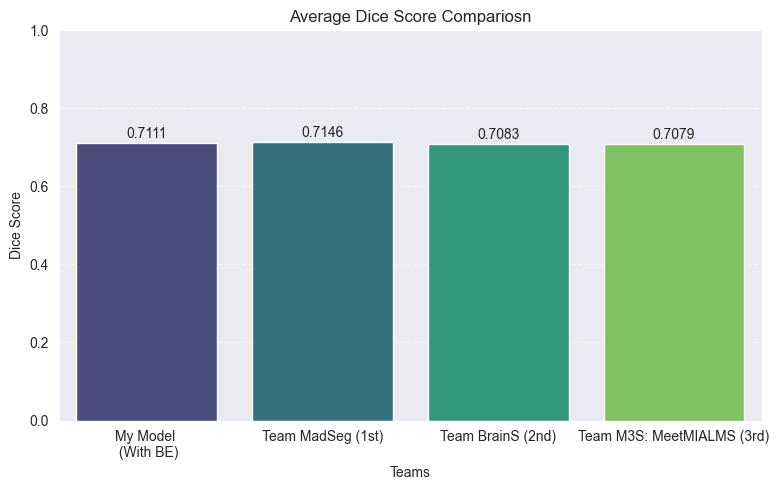

In [2]:

def plot_all_centers_from_list(values, labels, ylabel="Dice Score", title="Average Dice Score Compariosn"):

    plot_df = pd.DataFrame({
        "Teams": labels,
        "All Centers": values
    })
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_df, x="Teams", y="All Centers", palette="viridis")
    
    ax = plt.gca()
    for i, val in enumerate(values):
        ax.text(i, val + 0.005, f"{val:.4f}", ha="center", va="bottom", fontsize=10)
    
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("plots/average_dice_mslesseg.png")
    plt.show()


values = [0.7111, 0.7146, 0.7083, 0.7079]
labels = [
    "My Model \n (With BE)", 
    "Team MadSeg (1st)", 
    "Team BrainS (2nd)", 
    "Team M3S: MeetMIALMS (3rd)",
]

plot_all_centers_from_list(values, labels)